# Практическая работа № 4. 

## "Гистограмма как оценка плотости"

### Цель работы:

- ознакомиться с определением гистрограммы и ее поведением при фиксированном значении аргумента
- научиться находить значения гистограммы, строить ее график одновременно(в качестве тестового задания) с реальной плотностью генеральной совокупности
- убедиться в том, что асимптотические методы работают при конечном объеме выборки при корректном (с дополнительными требованиями) их использовании


### Задание и ход работы

Для случайной величины, распределенной по нормальному закону с параметрами $(a, \sigma^2)$, выполнить следующие действия:

- Задать параметры распределения $X$ ~ $N(a, \sigma^2)$
- Построить график $f_X(x)$
- При $n = 10^6$ построить выборку из генеральной совокупности $X$
- По построенной выборке вычислить значения и построить график гистограммы, используя при построении встроенную функцию для построения кусочно-постоянной функции
- Совместить графики плотности и гистограммы на одном рисунке
-  На основе хи-квадрат критерия Пирсона провести проверку гипотез согласия с семейством распределения генеральной совокупности
- Оценить ошибки I и II рода критерия

Сравнить с аналогичной обработкой выборки из равномерного распределения.

In [1]:
pkg load statistics
graphics_toolkit('gnuplot');


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.


In [2]:
% globals
global left = -10;
global right = 10;
global step = 0.01;
global n = 10^6;
global m = 10^2;
global figure_number = 1;

In [28]:
mu = 0;
sigma = 3;

a = -3;
b = 9;

In [4]:
function draw(a, b, pdf, rnd, plot_name)
    global left step right n m figure_number
    x = [left : step : right];
    y = pdf(x, a, b);
    X = sort(rnd(a, b, 1, n));
    h = (X(end) - X(1)) / m;
    y_hist = hist(X, m) / n / h;
    x_hist = [X(1) : h : X(end) - h];
    [x_hist, y_hist] = stairs(x_hist, y_hist);
    f = figure(figure_number++, "position", get(0, "screensize"));
    plot(x, y, x_hist, y_hist)
    title(plot_name);
    pause(0.01);
end

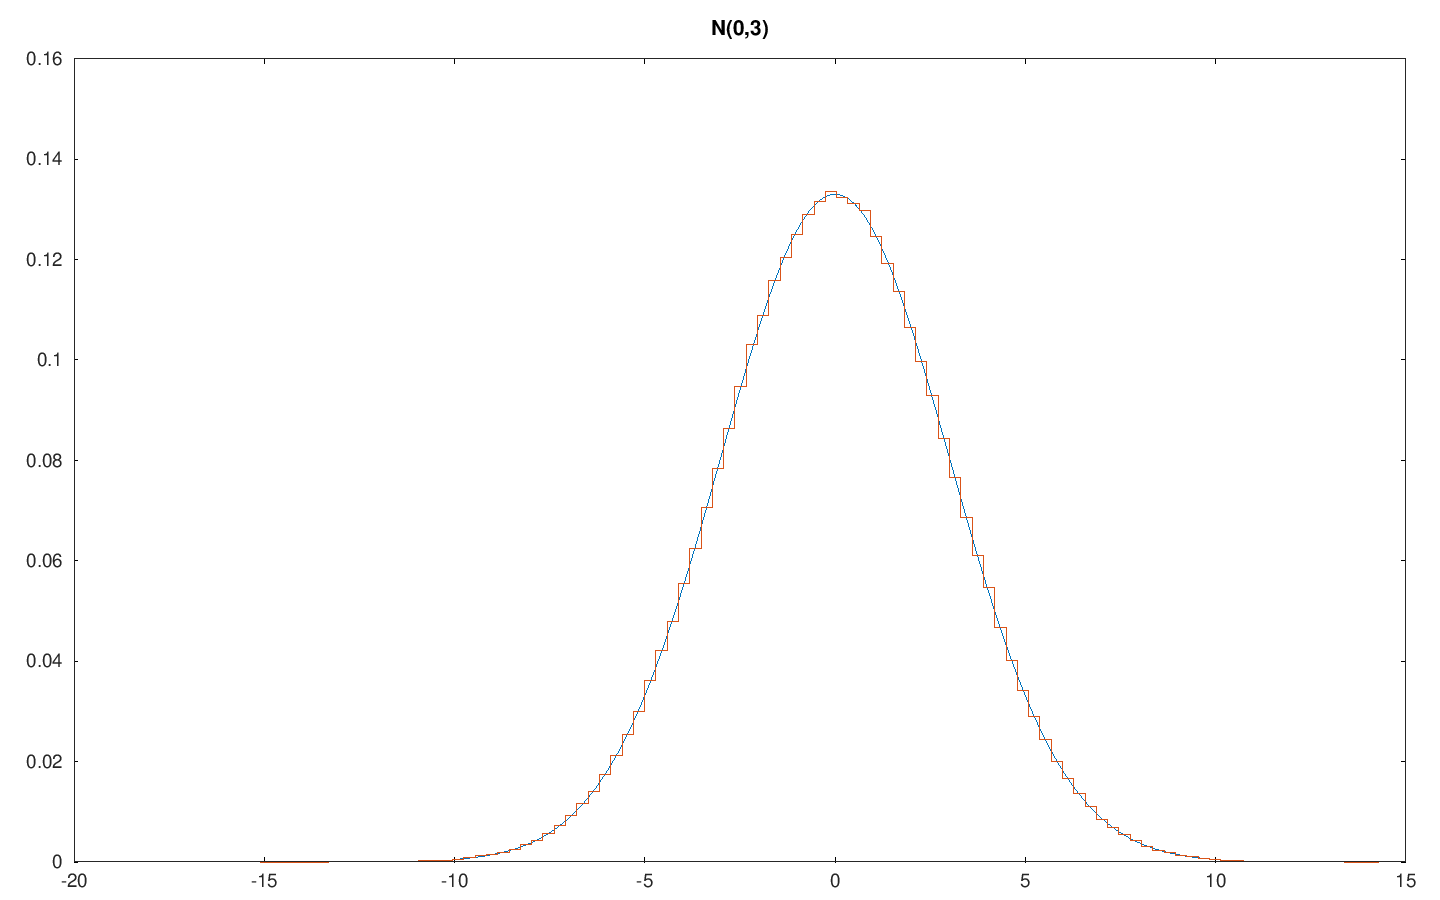

In [5]:
nd_title = strcat("N(", num2str(mu), ", ", num2str(sigma), ")");
draw(mu, sigma, @normpdf, @normrnd, nd_title);

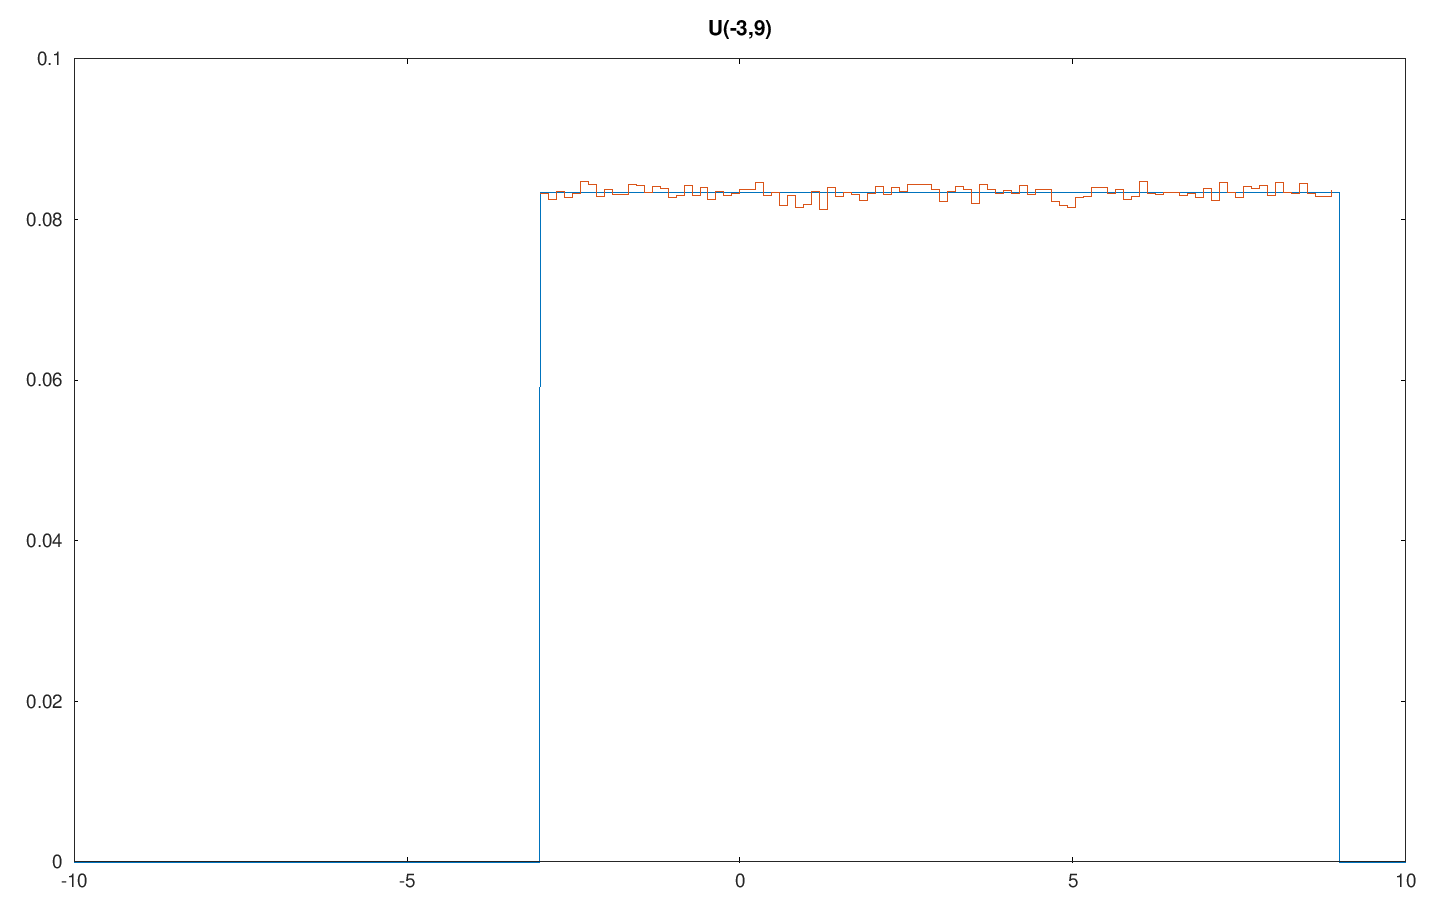

In [6]:
ud_title = strcat("U(", num2str(a), ", ", num2str(b), ")");
draw(a, b, @unifpdf, @unifrnd, ud_title);

In [7]:
function result = chisquare_test(a, b, delta1, delta2, gamma, is_norm)
    global n m
    
    if is_norm
        X = sort(normrnd(a, b, 1, n));
        ep1 = sum(X) / n;     
        ep2 = sqrt(sum((X - a) .^ 2) / (n - 1));
    else
        X = sort(unifrnd(a, b, 1, n));
        ep1 = X(1);
        ep2 = X(n);
    end
    
    h = (X(n) - X(1)) / m;
    hi = hist(X, m);
    
    ep1 += delta1;
    ep2 += delta2;
    chi = 0;
    i = 0;
    m1 = 0;
    
    while ++i <= m
        prev_i = i - 1;
        nj = hi(i);
        while nj < 6 && i < m
            i++;
            nj = nj + hi(i);
        end
        
        if is_norm
            p_i = (normcdf(X(1) + h*i, ep1, ep2) -
                   normcdf(X(1) + h*prev_i, ep1, ep2));
        else
            p_i = (unifcdf(X(1) + h*i, ep1, ep2) -
                   unifcdf(X(1) + h*prev_i, ep1, ep2));
        end

        chi = chi + (nj - n * p_i)^2 / (n * p_i);
        m1++;
    end

    result = chi >= chi2inv(gamma, m1 - 1);
end

__Norm_dist__

In [8]:
printf("Gamma: %f \nAcceptence: %f",
        0.9, 1 - chisquare_test(mu, sigma, 0, 0, 0.90, true))

Gamma: 0.900000 
Acceptence: 1.000000

In [9]:
printf("Gamma: %f \nAcceptence: %f",
        0.95, 1 - chisquare_test(mu, sigma, 0, 0, 0.95, true))

Gamma: 0.950000 
Acceptence: 1.000000

In [10]:
printf("Gamma: %f \nAcceptence: %f",
        0.99, 1 - chisquare_test(mu, sigma, 0, 0, 0.99, true))

Gamma: 0.990000 
Acceptence: 1.000000

__Unif_dist__

In [11]:
printf("Gamma: %f \nAcceptence: %f",
        0.9, 1 - chisquare_test(mu, sigma, 0, 0, 0.90, false))

Gamma: 0.900000 
Acceptence: 1.000000

In [27]:
printf("Gamma: %f \nAcceptence: %f",
        0.95, 1 - chisquare_test(mu, sigma, 0, 0, 0.95, false))

Gamma: 0.950000 
Acceptence: 1.000000

In [13]:
printf("Gamma: %f \nAcceptence: %f",
        0.99, 1 - chisquare_test(mu, sigma, 0, 0, 0.99, false))

Gamma: 0.990000 
Acceptence: 1.000000

In [14]:
global expr_cnt = 100;

function e = count_errors(a, b, delta1, delta2, gamma,
         is_norm, error_type)
    global expr_cnt;
    e = 0;
    for i = 1 : expr_cnt
        e += chisquare_test(a, b, delta1, delta2, gamma, is_norm);
    end
    
    if error_type == 2
        e = expr_cnt - e;
    end
    e /= expr_cnt;
end

__Norm_dist__

In [15]:
printf('Gamma: %f\nI error: %f',
        0.9, count_errors(mu, sigma, 0, 0, 0.9, true, 1))

Gamma: 0.900000
I error: 0.110000

In [16]:
printf('Gamma: %f\nI error: %f',
        0.95, count_errors(mu, sigma, 0, 0, 0.95, true, 1))

Gamma: 0.950000
I error: 0.050000

In [17]:
printf('Gamma: %f\nI error: %f',
        0.99, count_errors(mu, sigma, 0, 0, 0.99, true, 1))

Gamma: 0.990000
I error: 0.020000

In [18]:
printf('Gamma: %f\nII error: %f',
        0.9, count_errors(mu, sigma, 0, 0.01, 0.9, true, 2))

Gamma: 0.900000
II error: 0.440000

In [19]:
printf('Gamma: %f\nII error: %f',
        0.95, count_errors(mu, sigma, 0, 0.05, 0.95, true, 2))

Gamma: 0.950000
II error: 0.000000

In [20]:
printf('Gamma: %f\nII error: %f',
        0.99, count_errors(mu, sigma, 0, 0.1, 0.99, true, 2))

Gamma: 0.990000
II error: 0.000000

__Unif_dist__

In [21]:
printf('Gamma: %f\nI error: %f',
        0.9, count_errors(mu, sigma, 0, 0, 0.9, false, 1))

Gamma: 0.900000
I error: 0.090000

In [22]:
printf('Gamma: %f\nI error: %f',
        0.95, count_errors(mu, sigma, 0, 0, 0.95, false, 1))

Gamma: 0.950000
I error: 0.060000

In [23]:
printf('Gamma: %f\nI error: %f',
        0.99, count_errors(mu, sigma, 0, 0, 0.99, false, 1))

Gamma: 0.990000
I error: 0.010000

In [24]:
printf('Gamma: %f\nII error: %f',
        0.9, count_errors(mu, sigma, 0, 0.01, 0.9, false, 2))

Gamma: 0.900000
II error: 0.650000

In [25]:
printf('Gamma: %f\nII error: %f',
        0.95, count_errors(mu, sigma, 0, 0.05, 0.95, false, 2))

Gamma: 0.950000
II error: 0.000000

In [26]:
printf('Gamma: %f\nII error: %f',
        0.99, count_errors(mu, sigma, 0, 0.1, 0.99, false, 2))

Gamma: 0.990000
II error: 0.000000